In [1]:
import os

import sys
sys.path.append("C:\\Users\\User\\PycharmProjects\\GIEBN\\src")
sys.path.append("C:\\Users\\User\\PycharmProjects\\GIEBN")
sys.path.append("C:\\Users\\User\\PycharmProjects\\GIEBN\\venv")

path = os.getcwd()

curr_path = path.replace('\\', '/')
head_place = curr_path.find('GIEBN')
main_path = curr_path[:head_place]+'GIEBN'
main_path

'c:/Users/User/PycharmProjects/GIEBN'

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline, make_union
from sklearn.datasets import make_regression

from sklearn.model_selection import train_test_split

from auxiliary.auxiliary import construct_by_kmeans
from pgmpy.estimators import K2Score
from bamt.networks.discrete_bn import DiscreteBN
from bamt_inherited.networks.discrete import DiscreteBNGI
import shap

from tqdm import tqdm

imagespath = 'C://Users/User/PycharmProjects/GIEBN/experiments/shaplime/images'

In [106]:
%run ../common_code.ipynb

In [107]:
data = pd.read_csv("../../datasets/credit.csv")
print(data.columns)
#data = data.reset_index().drop(columns=["index"])
n_features = data.shape[1]-1
n = data.shape[0]
data["default"] = (data["NumberOfTimes90DaysLate"] > 0).astype(int)
data.drop(columns=["NumberOfTimes90DaysLate", 'NumberOfTime60-89DaysPastDueNotWorse', 'SeriousDlqin2yrs',
                   'NumberOfTime30-59DaysPastDueNotWorse'], inplace=True)
n_features = data.shape[1]-1
n = data.shape[0]
data.rename(columns={feat: "".join(feat.split("-")) for feat in data.columns}, inplace=True)
target = "default"
features = data.columns.difference([target]).tolist()

data.head(10)

Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'SeriousDlqin2yrs'],
      dtype='object')


,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,default
0,0.006999,38,0.302150,5440.0,4,1,3,0
1,0.704592,63,0.471441,8000.0,9,1,0,0
2,0.063113,57,0.068586,5000.0,17,0,0,0
3,0.368397,68,0.296273,6250.0,16,2,0,0
4,1.000000,34,0.000000,3500.0,0,0,1,0
5,0.051799,63,0.770687,4700.0,16,1,1,0
6,0.648733,40,0.402060,6600.0,10,2,3,0
7,0.767270,33,0.338390,5800.0,10,0,3,0
8,0.190111,27,0.164605,3960.0,6,0,1,0
9,0.139989,65,0.258397,6400.0,6,1,0,0


In [108]:
data_tv, data_test = train_test_split(data, test_size=0.15, random_state=42,
                                      stratify=data[target])

data_train, data_val = train_test_split(data_tv, test_size=0.15, random_state=42,
                                      stratify=data_tv[target])

data_train[target].mean(), data_val[target].mean() , data_test[target].mean()

(0.18476190476190477, 0.18488972313467855, 0.18460925039872408)

In [109]:
data_val.shape

(2131, 8)

In [110]:
model = GradientBoostingClassifier(n_estimators=30)
#model = LogisticRegression()
model.fit(data_train[features], data_train[target])

GradientBoostingClassifier(n_estimators=30)

In [111]:
data_errors = data_val.copy(deep=True)
probs = model.predict_proba(data_val[features])[:, 1]
data_errors["inconf_error"] = (1-probs)*data_val[target]+(probs)*(1-data_val[target]) #inconfidence measure: the larger the worser inconfidence

data_errors.drop(columns=[target], inplace=True)
data_errors.head()

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,inconf_error
700,1.000000,54,0.178841,3175.0,1,0,1,0.485031
15405,1.000000,35,0.000000,1800.0,0,0,0,0.573427
16522,0.197965,49,0.120713,9708.0,7,2,2,0.061616
3834,0.107234,80,0.271530,2960.0,8,1,0,0.054690
10225,0.594406,39,0.537291,4665.0,6,1,4,0.177077


In [112]:
disc_data, pipeline_data = discretize(data_errors, features+["inconf_error"], icat=None, icont=list(range(n_features+1)))
disc_data

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,inconf_error
0,2,1,0,0,0,1,2,2
1,2,0,0,0,0,1,1,2
2,1,1,0,2,0,2,2,0
3,0,2,1,0,0,2,1,0
4,1,0,2,1,0,2,2,1
...,...,...,...,...,...,...,...,...
2126,2,0,0,0,0,1,2,2
2127,2,0,0,1,0,1,1,2
2128,1,1,0,2,1,2,2,1
2129,2,0,0,1,0,1,2,2


In [ ]:
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.models import BayesianNetwork
import yodo.yodo
import matplotlib.pyplot as plt
from pgmpy.estimators import PC, BicScore
from pgmpy.inference import VariableElimination

In [115]:
n_states_map = {feat: disc_data[feat].unique().shape[0] for feat in data_errors.columns}
n_states_map

{'RevolvingUtilizationOfUnsecuredLines': 3,
 'age': 3,
 'DebtRatio': 3,
 'MonthlyIncome': 3,
 'NumberOfOpenCreditLinesAndLoans': 3,
 'NumberRealEstateLoansOrLines': 2,
 'NumberOfDependents': 2,
 'inconf_error': 3}

In [16]:
bn = DiscreteBN()
bn.add_nodes({"types": {feat: "disc" for feat in data_errors.columns}})

blacklist = [("inconf_error", x) for x in features]

In [17]:
bn.add_edges(disc_data, scoring_function=("K2", BicScore), params={"bl_add": blacklist})

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [18]:
bn.get_info()

,name,node_type,data_type,parents,parents_types
0,NumberOfOpenCreditLinesAndLoans,Discrete,disc,[],[]
1,NumberRealEstateLoansOrLines,Discrete,disc,[NumberOfOpenCreditLinesAndLoans],[disc]
2,MonthlyIncome,Discrete,disc,"[NumberOfOpenCreditLinesAndLoans, NumberRealEs...","[disc, disc]"
3,DebtRatio,Discrete,disc,"[MonthlyIncome, NumberRealEstateLoansOrLines]","[disc, disc]"
4,RevolvingUtilizationOfUnsecuredLines,Discrete,disc,"[DebtRatio, NumberOfOpenCreditLinesAndLoans]","[disc, disc]"
5,inconf_error,Discrete,disc,"[RevolvingUtilizationOfUnsecuredLines, NumberO...","[disc, disc]"
6,age,Discrete,disc,"[RevolvingUtilizationOfUnsecuredLines, NumberR...","[disc, disc]"
7,NumberOfDependents,Discrete,disc,[age],[disc]


In [19]:
from itertools import product

In [20]:
def extract_categories(data):
    return [f"{feat}_{int(k)}" for feat in data.columns for k in
            sorted(data[feat].unique())]
categories = extract_categories(disc_data)
encoder = OneHotEncoder(sparse=False)
disc_data_encoded = pd.DataFrame(encoder.fit_transform(X=disc_data), columns=categories, dtype='uint8')
disc_data_encoded

,RevolvingUtilizationOfUnsecuredLines_0,RevolvingUtilizationOfUnsecuredLines_1,RevolvingUtilizationOfUnsecuredLines_2,age_0,age_1,age_2,DebtRatio_0,DebtRatio_1,DebtRatio_2,MonthlyIncome_0,...,NumberOfOpenCreditLinesAndLoans_1,NumberOfOpenCreditLinesAndLoans_2,NumberRealEstateLoansOrLines_1,NumberRealEstateLoansOrLines_2,NumberOfDependents_0,NumberOfDependents_1,NumberOfDependents_2,inconf_error_0,inconf_error_1,inconf_error_2
0,0,0,1,0,1,0,1,0,0,1,...,0,0,1,0,1,0,0,0,0,1
1,0,0,1,1,0,0,1,0,0,1,...,0,0,1,0,1,0,0,0,0,1
2,0,1,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,1,0,0
3,1,0,0,0,0,1,0,1,0,1,...,0,0,0,1,1,0,0,1,0,0
4,0,1,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2126,0,0,1,1,0,0,1,0,0,1,...,0,0,1,0,0,1,0,0,0,1
2127,0,0,1,1,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,1
2128,0,1,0,0,1,0,1,0,0,0,...,1,0,0,1,0,1,0,0,1,0
2129,0,0,1,1,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,1


In [300]:
def gbn_training_pipeline(gbn, disc_data_encoded, error_name, categories):
    gbn.add_nodes({"types": {feat: "disc" for feat in disc_data_encoded.columns}})
    features_cats = [x for x in disc_data_encoded.columns if error_name not in x]
    error_cats = [x for x in disc_data_encoded.columns if error_name in x]

    blacklist = [(x, y) for x, y in product(error_cats, features_cats)] \
            + [(x, y) for x, y in product(categories, categories) if x.split("_")[:-1]==y.split("_")[:-1]]

    gbn.add_edges(disc_data_encoded, scoring_function=("K2", BicScore), params={"bl_add": blacklist})
    gbn.fit_parameters(data=disc_data_encoded, n_jobs=1)

In [301]:
gbn = DiscreteBNGI(imagespath)

gbn_training_pipeline(gbn, disc_data_encoded, 'inconf_error', categories)


2025-04-15 01:26:59,183 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 01:26:59,187 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 01:26:59,189 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 01:26:59,190 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 01:26:59,192 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 01:26:59,193 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 01:26:59,194 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 01:26:59,195 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 01:26:59,196 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 01:26:59,197 | ERROR    | GraphUtil

2025-04-15 01:26:59,205 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 01:26:59,207 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 01:26:59,209 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 01:26:59,210 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 01:26:59,212 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 01:26:59,213 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 01:26:59,214 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 01:26:59,215 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8


  0%|          | 0/1000000 [00:00<?, ?it/s]

In [329]:
import random
def get_all_predecessors(gbn, nodes):
    res = []
    iter_list=nodes
    while len(iter_list)>0:
        node = iter_list[0]
        iter_list=iter_list[1:]
        if gbn[node] is not None:
            pred = gbn[node].disc_parents
            if pred is not None:
                for p in pred:
                    if p not in res and p not in nodes:
                        res.append(p)
                        iter_list.append(p)
    return res


def get_prob(gbn, node, nodes_values):
    if len(gbn[node].disc_parents)==0:
        return gbn.get_dist(node)['cprob'][int(nodes_values[node])]
    else:
        return gbn.get_dist(node, nodes_values)[int(nodes_values[node])]

def calculate_cond_prob_support_old(gbn, e_grad, x_grad, random_state=42, k_random=1024):
    if x_grad in gbn[e_grad].disc_parents:
        pass

    if gbn[x_grad] is None: # x_grad node is detached from BN, they are independent
        return 0, 0
    
    e_parents = [x for x in gbn[e_grad].disc_parents if x != x_grad]

    for_product = [[0,1] for _ in range(len(e_parents))]

    all_other_predecessors = get_all_predecessors(gbn, e_parents+[x_grad])

    nodes_x_par = [node for node in all_other_predecessors if x_grad in gbn[node].disc_parents]
    nodes_x_notpar = [node for node in all_other_predecessors if x_grad not in gbn[node].disc_parents]

    to_iterate = [x_grad]+e_parents+all_other_predecessors

    s=0
    s_denom=0
    #print(len(for_product))
    for comb in product(*for_product):
        instantiated_nodes = {k: str(v) for k, v in zip(e_parents, comb)}
        instantiated_nodes[x_grad]='1'
        instantiated_nodes[e_grad]='1'
        #print(e_parentsp)
        e_prob = get_prob(gbn, e_grad, instantiated_nodes)

        for_product_others = [[0,1] for _ in range(len(all_other_predecessors))]
        # Можем разделить на тех, у кого x родитель и нет. Меньше варьируем
        s_inner=0

        if len(all_other_predecessors)>1000:
            random.seed(random_state)
            iter_set = random.sample(list(product(*for_product_others)), k_random)
        else:
            iter_set=product(*for_product_others)

        # for comb_others in iter_set:

        #     instantiated_others = {k:str(v) for k, v in zip(all_other_predecessors, 
        #                                                                       comb_others)}

        #     instantiated_nodes_all = {**instantiated_nodes, **instantiated_others}
        #     s_inner+=np.prod([get_prob(gbn, x, instantiated_nodes_all) for x in to_iterate])

        for comb_others in iter_set:

            instantiated_others = {k:str(v) for k, v in zip(all_other_predecessors, 
                                                                              comb_others)}

            instantiated_nodes_all = {**instantiated_nodes, **instantiated_others}
            s_inner+=np.prod([get_prob(gbn, x, instantiated_nodes_all) for x in to_iterate])

        s+=e_prob*s_inner
        s_denom+=s_inner
    return s, s_denom

def calculate_cond_prob_support(pgmpy_gbn, e_grad, x_grad):
    inference = VariableElimination(pgmpy_gbn)
    res_infer = inference.query([e_grad, x_grad])
    dict_to_get_value = {e_grad:1, x_grad:1}
    
    return res_infer.get_value(**dict_to_get_value)


def calculate_mutual_information(gbn, feat1, feat2, grad_map):
    joint_values = {(x, y): calculate_cond_prob_support(gbn, x, y)
                    for x, y in product(grad_map[feat1], grad_map[feat2])}
    
    all_sum = sum([x for x in joint_values.values()])
    print(all_sum)

    if all_sum == 0: # all gradations of feats are independent
        return 0

    joint_values = {k: v/all_sum for k, v in joint_values.items()}
    marg_probs = {}
    for grad in grad_map[feat1]:
        s=sum([v for k, v in joint_values.items() if k[0]==grad])
        marg_probs[grad]=s

    for grad in grad_map[feat2]:
        s=sum([v for k, v in joint_values.items() if k[1]==grad])
        marg_probs[grad]=s

    mutual_info = sum([joint_values[(x, y)]*np.log(joint_values[(x, y)]/(marg_probs[x]*marg_probs[y])
                                                   ) for x, y in product(grad_map[feat1], grad_map[feat2])])

    return mutual_info



In [ ]:
#from pgmpy import BayesianNetwork

In [323]:
feat_to_grad = {}
for feat in features+['inconf_error']:
    feat_to_grad[feat]=[grad for grad in disc_data_encoded.columns if feat in grad]
feat_to_grad

{'DebtRatio': ['DebtRatio_0', 'DebtRatio_1', 'DebtRatio_2'],
 'MonthlyIncome': ['MonthlyIncome_0', 'MonthlyIncome_1', 'MonthlyIncome_2'],
 'NumberOfDependents': ['NumberOfDependents_0',
  'NumberOfDependents_1',
  'NumberOfDependents_2'],
 'NumberOfOpenCreditLinesAndLoans': ['NumberOfOpenCreditLinesAndLoans_0',
  'NumberOfOpenCreditLinesAndLoans_1',
  'NumberOfOpenCreditLinesAndLoans_2'],
 'NumberRealEstateLoansOrLines': ['NumberRealEstateLoansOrLines_1',
  'NumberRealEstateLoansOrLines_2'],
 'RevolvingUtilizationOfUnsecuredLines': ['RevolvingUtilizationOfUnsecuredLines_0',
  'RevolvingUtilizationOfUnsecuredLines_1',
  'RevolvingUtilizationOfUnsecuredLines_2'],
 'age': ['age_0', 'age_1', 'age_2'],
 'inconf_error': ['inconf_error_0', 'inconf_error_1', 'inconf_error_2']}

In [331]:
calculate_mutual_information(pgmpy_gbn, 'inconf_error', 'age', feat_to_grad)

1.0739671116909353


0.014524049253140475

In [328]:
mutual_information(disc_data_encoded, 'inconf_error', 'RevolvingUtilizationOfUnsecuredLines', feat_to_grad)

0.338583564633012

In [ ]:
calculate_mutual_information(pgmpy_gbn, 'inconf_error', 'RevolvingUtilizationOfUnsecuredLines', feat_to_grad)

In [303]:
n_states_map

{'RevolvingUtilizationOfUnsecuredLines': 3,
 'age': 3,
 'DebtRatio': 3,
 'MonthlyIncome': 3,
 'NumberOfOpenCreditLinesAndLoans': 3,
 'NumberRealEstateLoansOrLines': 2,
 'NumberOfDependents': 2,
 'inconf_error': 3}

In [307]:
gbn.nodes[0].name

'age_1'

In [308]:
n_states_map_gbn = {feat.name: 2 for feat in gbn.nodes}
n_states_map_gbn

{'age_1': 2,
 'MonthlyIncome_1': 2,
 'NumberRealEstateLoansOrLines_1': 2,
 'NumberOfOpenCreditLinesAndLoans_0': 2,
 'RevolvingUtilizationOfUnsecuredLines_2': 2,
 'age_2': 2,
 'NumberOfDependents_0': 2,
 'RevolvingUtilizationOfUnsecuredLines_0': 2,
 'NumberOfDependents_2': 2,
 'DebtRatio_0': 2,
 'DebtRatio_1': 2,
 'age_0': 2,
 'inconf_error_2': 2,
 'RevolvingUtilizationOfUnsecuredLines_1': 2,
 'NumberOfOpenCreditLinesAndLoans_1': 2,
 'NumberOfDependents_1': 2,
 'MonthlyIncome_0': 2,
 'NumberRealEstateLoansOrLines_2': 2,
 'DebtRatio_2': 2,
 'NumberOfOpenCreditLinesAndLoans_2': 2,
 'inconf_error_0': 2,
 'MonthlyIncome_2': 2,
 'inconf_error_1': 2}

In [309]:
pgmpy_gbn = BayesianNetwork([list(e) for e in gbn.edges])
cpds = collect_all_cpds(gbn.get_info(), gbn.distributions, n_states_map_gbn)
for e in cpds:
    if len(e.variables) == 1: # либо узел без родителей, либо изолированный узел
        feat = e.variables[0]
        if not any([(feat in edge) for edge in gbn.edges]):
            continue
    pgmpy_gbn.add_cpds(e)

In [312]:
inference = VariableElimination(pgmpy_gbn)

In [320]:
res_infer = inference.query(['inconf_error_2'], evidence={'age_1':1})
res_infer.get_value(inconf_error_2=1)

0.42290622751702944

In [120]:
feat_to_grad = {}
for feat in features+['inconf_error']:
    feat_to_grad[feat]=[grad for grad in disc_data_encoded.columns if feat in grad]
feat_to_grad

{'DebtRatio': ['DebtRatio_0', 'DebtRatio_1', 'DebtRatio_2'],
 'MonthlyIncome': ['MonthlyIncome_0', 'MonthlyIncome_1', 'MonthlyIncome_2'],
 'NumberOfDependents': ['NumberOfDependents_0',
  'NumberOfDependents_1',
  'NumberOfDependents_2'],
 'NumberOfOpenCreditLinesAndLoans': ['NumberOfOpenCreditLinesAndLoans_0',
  'NumberOfOpenCreditLinesAndLoans_1',
  'NumberOfOpenCreditLinesAndLoans_2'],
 'NumberRealEstateLoansOrLines': ['NumberRealEstateLoansOrLines_1',
  'NumberRealEstateLoansOrLines_2'],
 'RevolvingUtilizationOfUnsecuredLines': ['RevolvingUtilizationOfUnsecuredLines_0',
  'RevolvingUtilizationOfUnsecuredLines_1',
  'RevolvingUtilizationOfUnsecuredLines_2'],
 'age': ['age_0', 'age_1', 'age_2'],
 'inconf_error': ['inconf_error_0', 'inconf_error_1', 'inconf_error_2']}

In [ ]:
#gbn.plot("credit_classif_other.html")

In [ ]:
gbn.get_dist('inconf_error_2', )

In [222]:
def error_based_importance(data, error_col, feature, feat_to_grad):
    error_probs = {grad: data[grad].mean() for grad in disc_data_encoded.columns if error_col in grad}
    s=0
    for grad in feat_to_grad[feature]:
        sub_sum = 0
        for e, p in error_probs.items():
            cprob = data[(data[e]==1)&(data[grad]==1)].shape[0]/data.shape[0]/data[grad].mean()
            sub_sum+=cprob*np.log(cprob/p) if cprob>0 else 0
        s+=data[grad].mean()*sub_sum
    return s

def mutual_information(data, error_col, feature, feat_to_grad):
    s=0
    for e_grad, f_grad in product([grad for grad in disc_data_encoded.columns if error_col in grad], 
                                  feat_to_grad[feature]):
        joint_prob = data[(data[e_grad]==1)&(data[f_grad]==1)].shape[0]/data.shape[0]
        px, py = data[e_grad].mean(), data[f_grad].mean()

        s+=joint_prob*np.log(joint_prob/px/py) if joint_prob>0 else 0

    return s

def error_based_importance_features(data, error_col, features, feat_to_grad):
    df = pd.DataFrame(columns=['Feature', 'Metric value'])
    for i, feature in enumerate(features):
        val = error_based_importance(data, error_col, feature, feat_to_grad)
        df.loc[i, :] = [feature, val]
    return df

def error_based_importance_features_bn(gbn, error_col, features, feat_to_grad):
    df = pd.DataFrame(columns=['Feature', 'Metric value'])
    for i, feature in tqdm(enumerate(features), total=len(features)):
        val = calculate_mutual_information(gbn, error_col, feature, feat_to_grad)
        df.loc[i, :] = [feature, val]
    return df

In [332]:
df_val_new=error_based_importance_features_bn(pgmpy_gbn, 'inconf_error', features, feat_to_grad)
df_val_new

 86%|████████▌ | 6/7 [00:00<00:00, 27.49it/s]

1.106681631626811
1.2488163770764706
0.9850564879767624
0.8653296683944021
0.9608054012562867
1.0286915091199893


100%|██████████| 7/7 [00:00<00:00, 24.92it/s]

1.0739671116909353


,Feature,Metric value
0,DebtRatio,0.00688
1,MonthlyIncome,0.000851
2,NumberOfDependents,0.000628
3,NumberOfOpenCreditLinesAndLoans,0.0009
4,NumberRealEstateLoansOrLines,0.005179
5,RevolvingUtilizationOfUnsecuredLines,0.03768
6,age,0.014524


In [333]:
df_val=error_based_importance_features(disc_data_encoded, 'inconf_error', features, feat_to_grad)
df_val

,Feature,Metric value
0,DebtRatio,0.023985
1,MonthlyIncome,0.037991
2,NumberOfDependents,0.003915
3,NumberOfOpenCreditLinesAndLoans,0.064241
4,NumberRealEstateLoansOrLines,0.04255
5,RevolvingUtilizationOfUnsecuredLines,0.338584
6,age,0.04856


In [334]:
df2 = df_val[['Feature']]
df2['Metric value 1 rank'] = df_val['Metric value'].rank()
df2['Metric value 2 rank'] = df_val_new['Metric value'].rank()
df2

,Feature,Metric value 1 rank,Metric value 2 rank
0,DebtRatio,2.0,5.0
1,MonthlyIncome,3.0,2.0
2,NumberOfDependents,1.0,1.0
3,NumberOfOpenCreditLinesAndLoans,6.0,3.0
4,NumberRealEstateLoansOrLines,4.0,4.0
5,RevolvingUtilizationOfUnsecuredLines,7.0,7.0
6,age,5.0,6.0


In [125]:
def plot_bar_chart(df_values, fontsize=14):
    df_values.plot.barh(figsize=(10, 6))
    ax=plt.gca()
    ax.barh(df_values['Feature'], df_values['Metric value'], height=0.75)
    _, xmax = plt.xlim()
    for i, row in df_values.iterrows():
        ax.text(row['Metric value'] if 2*row['Metric value'] < xmax else xmax-row['Metric value'], 
                i, row['Feature'], color='black', fontweight='bold', fontsize=fontsize, ha='left', va='center')

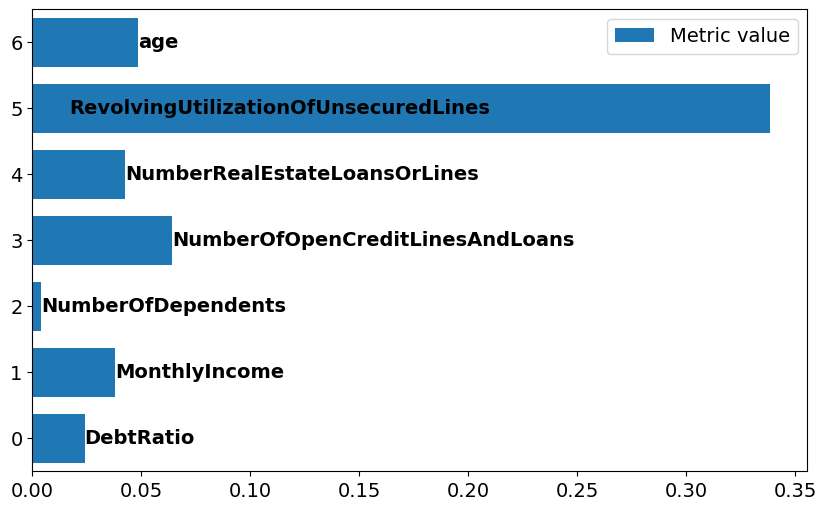

In [126]:
plot_bar_chart(df_val, fontsize=14)

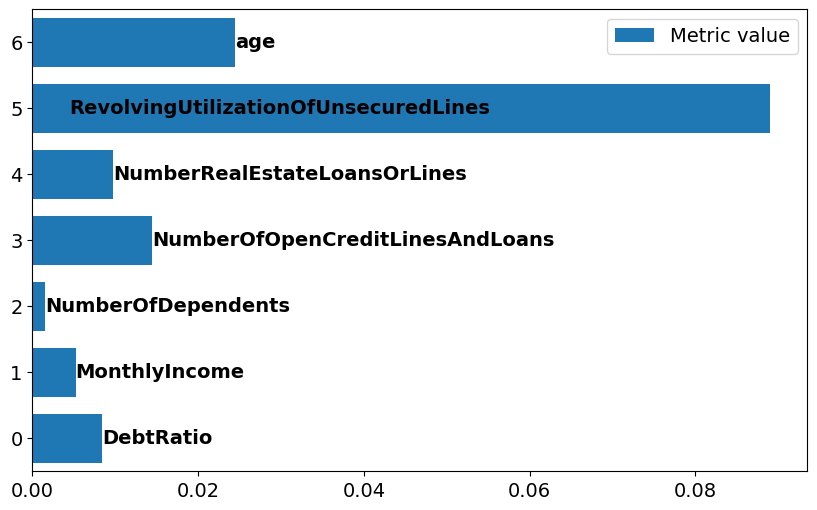

In [127]:
plot_bar_chart(df_val_new, fontsize=14)

In [128]:
from sklearn.metrics import roc_auc_score, log_loss
from copy import copy

In [129]:
def elimination_experiment(model, data_dict, metric_dict, importances, direction='asc'):
    ordered_features = importances.sort_values(by='Metric value', ascending=(direction=='asc'))
    ordered_features = ordered_features['Feature'].tolist()
    df_res = pd.DataFrame(columns=['n_features', 'last_excluded']+[m_name for m_name in metric_dict.keys()]\
                                                                +[m_name+'_change, %' for m_name in metric_dict.keys()])
    for i in range(len(ordered_features)):
        model_c = copy(model)
        features_chosen = ordered_features[i:]
        model_c.fit(data_dict['train'][features_chosen], data_dict['train'][target])

        y_pred_test = model_c.predict_proba(data_dict['test'][features_chosen])[:, 1]
        metrics_vals = []
        metrics_chng=[]
        for m_name, metric in metric_dict.items():
            val = metric(data_dict['test'][target], y_pred_test)
            metrics_vals.append(np.round(val, 3))
            if i == 0:
                metrics_chng.append(0)
            else:
                base = df_res.loc[0, m_name]
                metrics_chng.append(np.round((val-base)/base*100, 3))
        df_res.loc[i, :] = [len(features_chosen), ordered_features[i-1] if i > 0 else '-']+metrics_vals+metrics_chng
    return df_res



In [130]:
metric_dict = {
    'ROC AUC': lambda x, y: roc_auc_score(x,y)*100,
    'log_loss': lambda x, y: log_loss(x, y)
}

data_dict = {'train': data_train,
             'test': data_test,
             'val': data_val}

elimination_experiment(model, data_dict, metric_dict,
                       df_val, 'asc')

,n_features,last_excluded,ROC AUC,log_loss,"ROC AUC_change, %","log_loss_change, %"
0,7,-,80.189,0.391,0,0
1,6,NumberOfDependents,80.155,0.391,-0.042,0.071
2,5,DebtRatio,80.034,0.392,-0.193,0.258
3,4,MonthlyIncome,79.841,0.393,-0.435,0.438
4,3,NumberRealEstateLoansOrLines,79.53,0.394,-0.822,0.794
5,2,age,79.353,0.395,-1.042,1.071
6,1,NumberOfOpenCreditLinesAndLoans,78.293,0.4,-2.365,2.352


In [47]:
elimination_experiment(model, data_dict, metric_dict,
                       df_val, 'desc')

,n_features,last_excluded,ROC AUC,log_loss,"ROC AUC_change, %","log_loss_change, %"
0,7,-,80.189,0.391,0,0
1,6,RevolvingUtilizationOfUnsecuredLines,72.306,0.43,-9.83,9.871
2,5,NumberOfOpenCreditLinesAndLoans,68.606,0.446,-14.445,14.139
3,4,age,67.055,0.452,-16.379,15.57
4,3,NumberRealEstateLoansOrLines,65.675,0.456,-18.1,16.513
5,2,MonthlyIncome,56.868,0.471,-29.083,20.551
6,1,DebtRatio,55.076,0.476,-31.317,21.618


In [131]:
elimination_experiment(model, data_dict, metric_dict,
                       df_val_new, 'asc')

,n_features,last_excluded,ROC AUC,log_loss,"ROC AUC_change, %","log_loss_change, %"
0,7,-,80.189,0.391,0,0
1,6,NumberOfDependents,80.155,0.391,-0.042,0.071
2,5,MonthlyIncome,80.049,0.392,-0.174,0.269
3,4,DebtRatio,79.841,0.393,-0.435,0.438
4,3,NumberRealEstateLoansOrLines,79.53,0.394,-0.822,0.794
5,2,NumberOfOpenCreditLinesAndLoans,78.687,0.4,-1.873,2.276
6,1,age,78.293,0.4,-2.365,2.352


In [132]:
def add_extra_features(data, features_orig,extra_size=0.5, mode='random', random_seed=42):
    extra_cnt = round(len(features_orig)/(1-extra_size))-len(features_orig)
    data_c = data.copy(deep=True)
    np.random.seed(random_seed)
    if mode=='random':
        for i in range(extra_cnt):
            std = np.random.uniform(0.75, 1.25)
            data_c[f'extra_{i+1}'] = np.random.normal(scale=std, size=data_c.shape[0])
    elif mode=='noisy':
        for i in range(extra_cnt):
            feature_chosen = np.random.choice(features_orig, size=1)[0]
            std = data[feature_chosen].std()
            data_c[f'extra_{i+1}'] = 0.5*data[feature_chosen]+0.5*np.random.normal(scale=std, size=data_c.shape[0])
    elif mode=='prod':
        first_subset=np.random.choice(features_orig, size=extra_cnt)
        second_subset=np.random.choice(features_orig, size=extra_cnt)
        i=0
        for feat1, feat2 in zip(first_subset, second_subset):
            data_c[f'extra_{i+1}'] = data[feat1]*data[feat2]
            i+=1
    return data_c

In [134]:
from sklearn.feature_selection import SelectKBest

In [284]:
data_corr = add_extra_features(data, features, extra_size=0.3, mode='noisy')

In [285]:
data_dict_corr = {}

data_tv, data_dict_corr['test'] = train_test_split(data_corr, test_size=0.15, random_state=42,
                                      stratify=data_corr[target])

data_dict_corr['train'], data_dict_corr['val'] = train_test_split(data_tv, test_size=0.15, random_state=42,
                                      stratify=data_tv[target])

features_corr = list(data_corr.columns.difference([target]))

In [286]:
univ_sel = SelectKBest(k=len(features_corr))
univ_sel.fit(data_dict_corr['val'][features_corr], data_dict_corr['val'][target])

SelectKBest()

In [289]:
univ_sel.scores_

array([3.53346759e+00, 1.11572908e+01, 3.47371081e+00, 1.19869999e+02,
       3.72085916e+01, 4.04584783e-02, 3.11269809e+01, 2.54997454e+01,
       3.74590541e+01, 1.24514926e+01])

In [290]:
univ_sel.feature_names_in_

array(['DebtRatio', 'MonthlyIncome', 'NumberOfDependents',
       'NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines',
       'RevolvingUtilizationOfUnsecuredLines', 'age', 'extra_1',
       'extra_2', 'extra_3'], dtype=object)

In [291]:
data_dict_corr['train'].shape

(12075, 11)

In [292]:
model_corr = GradientBoostingClassifier(n_estimators=30)
#model = LogisticRegression()
model_corr.fit(data_dict_corr['train'][features_corr], data_dict_corr['train'][target])

GradientBoostingClassifier(n_estimators=30)

In [293]:
data_errors_corr = data_dict_corr['val'].copy(deep=True)
probs = model_corr.predict_proba(data_dict_corr['val'][features_corr])[:, 1]
data_errors_corr["inconf_error"] = (1-probs)*data_dict_corr['val'][target]+(probs)*(1-data_dict_corr['val'][target]) #inconfidence measure: the larger the worser inconfidence

data_errors_corr.drop(columns=[target], inplace=True)
data_errors_corr.head()

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,extra_1,extra_2,extra_3,inconf_error
700,1.000000,54,0.178841,3175.0,1,0,1,30.572440,0.343745,12.909635,0.484913
15405,1.000000,35,0.000000,1800.0,0,0,0,23.027242,-0.913128,20.002182,0.575331
16522,0.197965,49,0.120713,9708.0,7,2,2,30.293397,1.102639,32.365268,0.059073
3834,0.107234,80,0.271530,2960.0,8,1,0,45.016820,0.283824,46.110528,0.055797
10225,0.594406,39,0.537291,4665.0,6,1,4,22.249169,1.037219,17.171984,0.171564


In [294]:
n_features_corr = len(features_corr)
disc_data_corr, pipeline_data_corr = discretize(data_errors_corr, 
                                      features_corr+["inconf_error"], icat=None, icont=list(range(n_features_corr+1)))
disc_data_corr

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,extra_1,extra_2,extra_3,inconf_error
0,2,1,0,0,0,1,2,1,1,0,2
1,2,0,0,0,0,1,1,1,0,1,2
2,1,1,0,2,0,2,2,1,1,2,0
3,0,2,1,0,0,2,1,2,1,2,0
4,1,0,2,1,0,2,2,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
2126,2,0,0,0,0,1,2,0,0,1,2
2127,2,0,0,1,0,1,1,1,0,1,2
2128,1,1,0,2,1,2,2,1,1,1,0
2129,2,0,0,1,0,1,2,1,0,0,2


In [295]:
categories_corr = extract_categories(disc_data_corr)
encoder = OneHotEncoder(sparse=False)
disc_data_encoded_corr = pd.DataFrame(encoder.fit_transform(X=disc_data_corr), columns=categories_corr, dtype='uint8')
disc_data_encoded_corr

,RevolvingUtilizationOfUnsecuredLines_0,RevolvingUtilizationOfUnsecuredLines_1,RevolvingUtilizationOfUnsecuredLines_2,age_0,age_1,age_2,DebtRatio_0,DebtRatio_1,DebtRatio_2,MonthlyIncome_0,...,extra_1_2,extra_2_0,extra_2_1,extra_2_2,extra_3_0,extra_3_1,extra_3_2,inconf_error_0,inconf_error_1,inconf_error_2
0,0,0,1,0,1,0,1,0,0,1,...,0,0,1,0,1,0,0,0,0,1
1,0,0,1,1,0,0,1,0,0,1,...,0,1,0,0,0,1,0,0,0,1
2,0,1,0,0,1,0,1,0,0,0,...,0,0,1,0,0,0,1,1,0,0
3,1,0,0,0,0,1,0,1,0,1,...,1,0,1,0,0,0,1,1,0,0
4,0,1,0,1,0,0,0,0,1,0,...,0,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2126,0,0,1,1,0,0,1,0,0,1,...,0,1,0,0,0,1,0,0,0,1
2127,0,0,1,1,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,1
2128,0,1,0,0,1,0,1,0,0,0,...,0,0,1,0,0,1,0,1,0,0
2129,0,0,1,1,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,1


In [296]:
gbn_fs = DiscreteBNGI(imagespath)

gbn_training_pipeline(gbn_fs, disc_data_encoded_corr, 'inconf_error', categories_corr)

2025-04-15 00:07:59,606 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 00:07:59,608 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 00:07:59,611 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8


2025-04-15 00:07:59,613 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 00:07:59,615 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 00:07:59,616 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 00:07:59,616 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 00:07:59,617 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 00:07:59,618 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 00:07:59,619 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 00:07:59,621 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 00:07:59,622 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 00:07:59,624 | ERROR    | GraphUtil

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [297]:
feat_to_grad_corr = {}
for feat in features_corr+['inconf_error']:
    feat_to_grad_corr[feat]=[grad for grad in disc_data_encoded_corr.columns if feat in grad]
feat_to_grad_corr

{'DebtRatio': ['DebtRatio_0', 'DebtRatio_1', 'DebtRatio_2'],
 'MonthlyIncome': ['MonthlyIncome_0', 'MonthlyIncome_1', 'MonthlyIncome_2'],
 'NumberOfDependents': ['NumberOfDependents_1', 'NumberOfDependents_2'],
 'NumberOfOpenCreditLinesAndLoans': ['NumberOfOpenCreditLinesAndLoans_0',
  'NumberOfOpenCreditLinesAndLoans_1',
  'NumberOfOpenCreditLinesAndLoans_2'],
 'NumberRealEstateLoansOrLines': ['NumberRealEstateLoansOrLines_1',
  'NumberRealEstateLoansOrLines_2'],
 'RevolvingUtilizationOfUnsecuredLines': ['RevolvingUtilizationOfUnsecuredLines_0',
  'RevolvingUtilizationOfUnsecuredLines_1',
  'RevolvingUtilizationOfUnsecuredLines_2'],
 'age': ['age_0', 'age_1', 'age_2'],
 'extra_1': ['extra_1_0', 'extra_1_1', 'extra_1_2'],
 'extra_2': ['extra_2_0', 'extra_2_1', 'extra_2_2'],
 'extra_3': ['extra_3_0', 'extra_3_1', 'extra_3_2'],
 'inconf_error': ['inconf_error_0', 'inconf_error_1', 'inconf_error_2']}

In [298]:
df_val_corr_bn=error_based_importance_features_bn(gbn_fs, 'inconf_error', features_corr, feat_to_grad_corr)
df_val_corr_bn

100%|██████████| 10/10 [02:27<00:00, 14.73s/it]


,Feature,Metric value
0,DebtRatio,0.063572
1,MonthlyIncome,0.028246
2,NumberOfDependents,0.129697
3,NumberOfOpenCreditLinesAndLoans,0.016369
4,NumberRealEstateLoansOrLines,0.072223
5,RevolvingUtilizationOfUnsecuredLines,0.033336
6,age,0.008476
7,extra_1,0.003468
8,extra_2,0.008786
9,extra_3,0.001981


In [278]:
df_val_corr_univ = copy(df_val_corr_bn)
df_val_corr_univ['Feature']=univ_sel.feature_names_in_
df_val_corr_univ['Metric value']=univ_sel.pvalues_
df_val_corr_univ

,Feature,Metric value
0,DebtRatio,6.027834e-02
1,MonthlyIncome,8.514686e-04
2,NumberOfDependents,6.248885e-02
3,NumberOfOpenCreditLinesAndLoans,3.530377e-27
4,NumberRealEstateLoansOrLines,1.257226e-09
5,RevolvingUtilizationOfUnsecuredLines,8.406060e-01
6,age,2.724594e-08
7,extra_1,4.800654e-07
8,extra_2,1.108156e-09


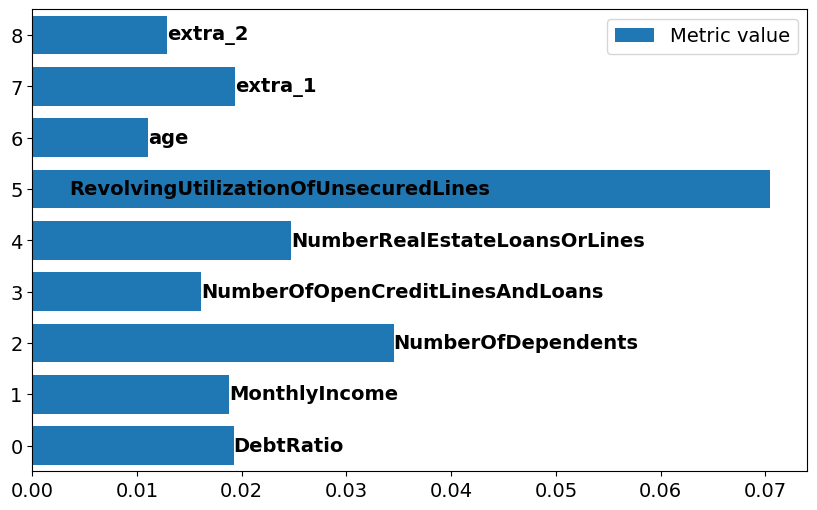

In [279]:
plot_bar_chart(df_val_corr_bn, fontsize=14)

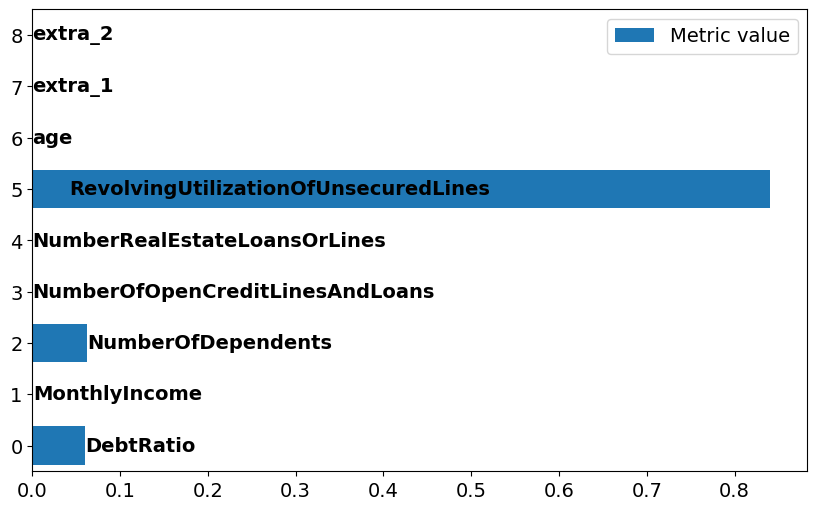

In [280]:
plot_bar_chart(df_val_corr_univ, fontsize=14)

In [281]:
df_corr_excluded_asc=elimination_experiment(model_corr, data_dict_corr, metric_dict,
                       df_val_corr_bn, 'asc')
df_corr_excluded_asc

,n_features,last_excluded,ROC AUC,log_loss,"ROC AUC_change, %","log_loss_change, %"
0,9,-,80.157,0.392,0,0
1,8,age,80.053,0.391,-0.13,-0.148
2,7,extra_2,80.053,0.392,-0.129,-0.049
3,6,NumberOfOpenCreditLinesAndLoans,79.603,0.395,-0.691,0.688
4,5,MonthlyIncome,79.338,0.397,-1.022,1.266
5,4,DebtRatio,79.121,0.397,-1.293,1.369
6,3,extra_1,79.041,0.397,-1.392,1.272
7,2,NumberRealEstateLoansOrLines,78.405,0.4,-2.186,1.992
8,1,NumberOfDependents,78.293,0.4,-2.326,2.091


In [282]:
df_corr_excluded_asc_univ=elimination_experiment(model_corr, data_dict_corr, metric_dict,
                       df_val_corr_univ, 'desc')
df_corr_excluded_asc_univ

,n_features,last_excluded,ROC AUC,log_loss,"ROC AUC_change, %","log_loss_change, %"
0,9,-,80.155,0.392,0,0
1,8,RevolvingUtilizationOfUnsecuredLines,72.087,0.43,-10.066,9.739
2,7,NumberOfDependents,72.152,0.43,-9.984,9.749
3,6,DebtRatio,70.95,0.435,-11.484,11.087
4,5,MonthlyIncome,69.691,0.439,-13.054,11.98
5,4,extra_1,69.589,0.439,-13.182,12.042
6,3,age,66.433,0.449,-17.119,14.496
7,2,NumberRealEstateLoansOrLines,67.138,0.447,-16.24,14.137
8,1,extra_2,66.5,0.449,-17.035,14.471


In [283]:
df_corr_excluded_asc_univ=elimination_experiment(model_corr, data_dict_corr, metric_dict,
                       df_val_corr_univ, 'asc')
df_corr_excluded_asc_univ

,n_features,last_excluded,ROC AUC,log_loss,"ROC AUC_change, %","log_loss_change, %"
0,9,-,80.157,0.392,0,0
1,8,NumberOfOpenCreditLinesAndLoans,79.833,0.394,-0.405,0.462
2,7,extra_2,79.78,0.394,-0.47,0.569
3,6,NumberRealEstateLoansOrLines,79.752,0.395,-0.505,0.64
4,5,age,79.598,0.395,-0.697,0.719
5,4,extra_1,79.515,0.395,-0.8,0.841
6,3,MonthlyIncome,78.679,0.399,-1.844,1.84
7,2,DebtRatio,78.405,0.4,-2.186,1.992
8,1,NumberOfDependents,78.293,0.4,-2.326,2.091


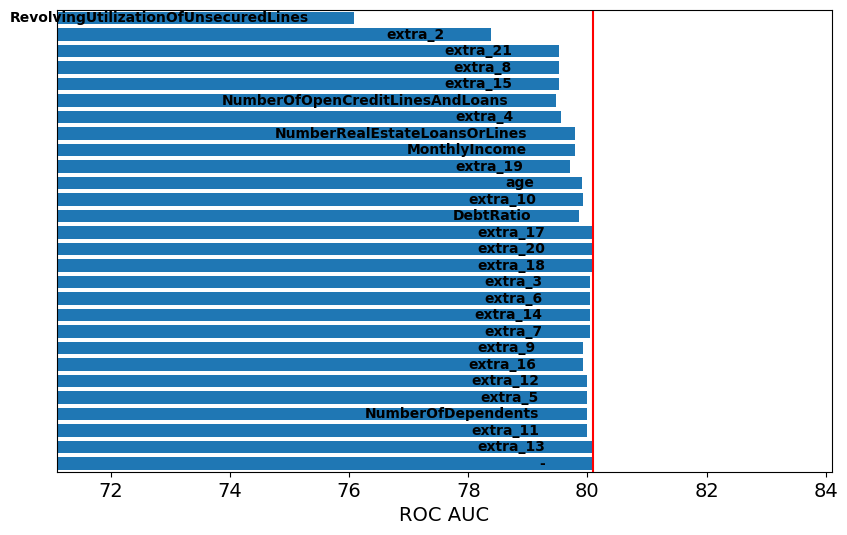

In [236]:
metr = 'ROC AUC'
df_corr_excluded_asc[['last_excluded', metr]].plot.barh(figsize=(10, 6))
ax=plt.gca()
ax.barh(df_corr_excluded_asc['last_excluded'], df_corr_excluded_asc[metr], height=0.75)
_, xmax = plt.xlim()
#ax.set_xlim((df_corr_excluded_asc[metr].min()-10, xmax))
for i, row in df_corr_excluded_asc.iterrows():
    ax.text(row[metr]*0.99,# if 2*row[metr] < xmax else xmax-row[metr], 
            i, row['last_excluded'], color='black', fontweight='bold', fontsize=10, ha='right', va='center')
ax.set_xlim((df_corr_excluded_asc[metr].min()-5, xmax))
ax.axvline(df_corr_excluded_asc.loc[0, metr], color='red')
ax.get_legend().remove()
ax.set_xlabel(metr)
ax.set_ylabel('Last removed feature')
ax.get_yaxis().set_visible(False)


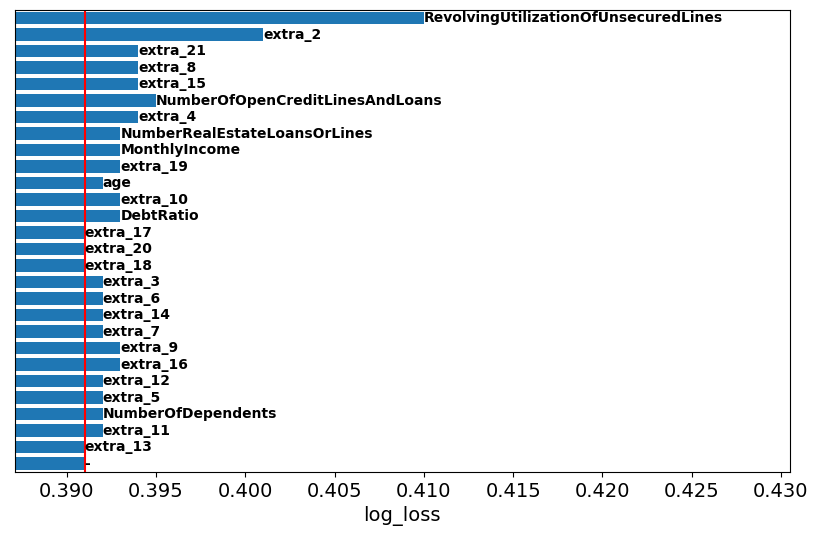

In [237]:
metr = 'log_loss'
df_corr_excluded_asc[['last_excluded', metr]].plot.barh(figsize=(10, 6))
ax=plt.gca()
ax.barh(df_corr_excluded_asc['last_excluded'], df_corr_excluded_asc[metr], height=0.75)
_, xmax = plt.xlim()
#ax.set_xlim((df_corr_excluded_asc[metr].min()-10, xmax))
for i, row in df_corr_excluded_asc.iterrows():
    ax.text(row[metr],# if 2*row[metr] < xmax else xmax-row[metr], 
            i, row['last_excluded'], color='black', fontweight='bold', fontsize=10, ha='left', va='center')
ax.set_xlim((df_corr_excluded_asc[metr].min()*0.99, xmax))
ax.axvline(df_corr_excluded_asc.loc[0, metr], color='red')
ax.get_legend().remove()
ax.set_xlabel(metr)
ax.set_ylabel('Last removed feature')
ax.get_yaxis().set_visible(False)


In [162]:
df_corr_excluded_asc[metr].min()-10

-9.609

In [101]:
elimination_experiment(model_corr, data_dict_corr, metric_dict,
                       df_val_corr, 'desc')

,n_features,last_excluded,ROC AUC,log_loss,"ROC AUC_change, %","log_loss_change, %"
0,14,-,80.089,0.392,0,0
1,13,RevolvingUtilizationOfUnsecuredLines,71.856,0.431,-10.28,9.996
2,12,NumberOfOpenCreditLinesAndLoans,68.545,0.447,-14.415,13.987
3,11,NumberRealEstateLoansOrLines,67.653,0.45,-15.527,14.864
4,10,MonthlyIncome,62.352,0.463,-22.147,18.155
5,9,age,56.637,0.472,-29.282,20.436
6,8,DebtRatio,53.416,0.48,-33.304,22.353
7,7,extra_7,54.545,0.478,-31.895,21.987
8,6,extra_3,54.271,0.477,-32.237,21.793
9,5,NumberOfDependents,51.456,0.479,-35.751,22.173


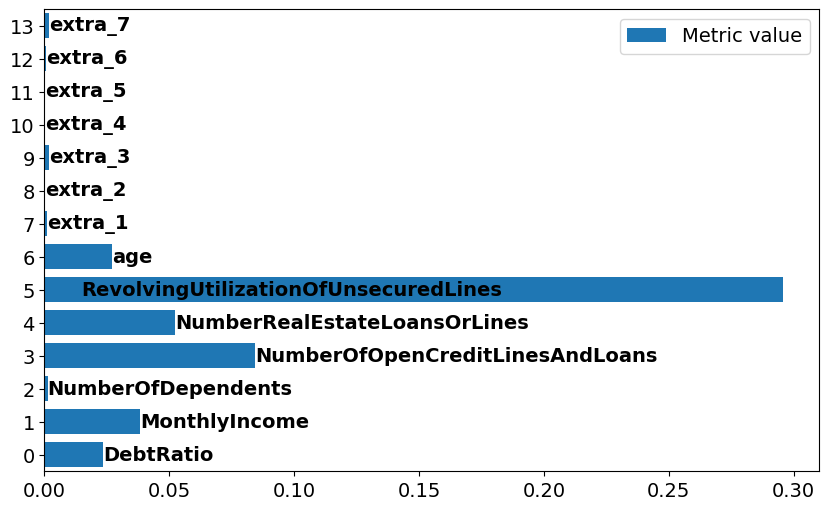

In [94]:
df_val_corr.plot.barh(figsize=(10, 6))
ax=plt.gca()
ax.barh(df_val_corr['Feature'], df_val_corr['Metric value'], height=0.75)
_, xmax = plt.xlim()
for i, row in df_val_corr.iterrows():
    ax.text(row['Metric value'] if 2*row['Metric value'] < xmax else xmax-row['Metric value'], 
            i, row['Feature'], color='black', fontweight='bold', fontsize=14, ha='left', va='center')

In [ ]:
df_val_corr=error_based_importance_features(disc_data_encoded, 'inconf_error', features)
df_val_corr

In [ ]:
# наша метрика -- это же по сути взаимная информация

In [71]:
from sklearn.feature_selection import mutual_info_classif

In [72]:
mutual_info_classif(X=disc_data[['age']], y=disc_data['inconf_error'])

array([0.05289194])

In [63]:
disc_data

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,inconf_error
0,2,1,0,0,0,1,0,2
1,2,0,0,0,0,1,0,2
2,1,1,0,2,0,2,1,0
3,0,2,1,0,0,2,0,0
4,1,0,2,1,0,2,2,1
...,...,...,...,...,...,...,...,...
2126,2,0,0,0,0,1,1,2
2127,2,0,0,1,0,1,0,2
2128,1,1,0,2,1,2,1,1
2129,2,0,0,1,0,1,0,2
